# 3) Feature Selection

In the previous notebook (**1_Feature_Extraction**), we performed feature extraction to transform the raw EEG signals into meaningful representations. These extracted features capture important characteristics of the time series, making them more suitable for classification.  

In this notebook, we will focus on **feature selection**, but first, we load the transformed dataset containing the extracted features.

In [18]:
# Import libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

from scipy.stats import skew, kurtosis, shapiro, anderson, normaltest, kstest
from sklearn.preprocessing import StandardScaler

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC

In [5]:
df_features = pd.read_csv("transformed_df.csv") # features dataframe that contains labels
features_df = df_features.drop(columns="y") # save a dataframe with only the features, if needed later

The next cell generates a pairplot to explore relationships between all extracted features. However, due to the high dimensionality of the dataset, plotting all features can be computationally expensive and time-consuming. For this reason, the code is currently commented out in the notebook.  

If you wish to visualize the pairplot without running the code, a precomputed version is available in this repository as **`pairplot.png`**.


In [1]:
# Takes a bit to execute
# sns.pairplot(df_features, hue="y")

## Individual Feature Discriminative Power

There are multiple feature selection strategies that help assess the discriminative power of individual variables, such as the Student's t-test and ANOVA tables. However, these tests rely on the assumption that the variable follows a normal distribution. Before applying these techniques, we will first evaluate the normality of the features by comparing the results of four widely used normality tests:

- **Shapiro-Wilk Test**: The Shapiro-Wilk test performs well for small sample sizes (\(<2000\) observations). However, it may fail to provide reliable results for large samples.

- **Kolmogorov-Smirnov (KS) Test**: The Kolmogorov-Smirnov test evaluates the discrepancy between the empirical cumulative distribution function (ECDF) of the sample and a specified theoretical cumulative distribution function (CDF). Although it is a well-established method, it is particularly sensitive to extreme values (outliers).

- **Anderson-Darling Test**: The Anderson-Darling test is conceptually similar to the Kolmogorov-Smirnov test but applies a weighting scheme that gives more importance to the tails of the distribution. It provides critical values that facilitate interpretation without requiring a \(p\)-value.

- **D’Agostino-Pearson Test**: The D’Agostino-Pearson test assesses normality by analyzing skewness (third standardized moment) and kurtosis (fourth standardized moment). This test is more robust for large sample sizes.


In addition to the tests, we have also generated the histograms for all features to gain an initial understanding of their distributions. This allows us to quickly assess the normality of the variables and identify potential skewness, outliers, or other patterns in the data.  


In [6]:
def test_normality(data, feature_name):
    print(f"\nTest results for: {feature_name}")

    # Test Shapiro-Wilk
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk: Stat={stat:.4f}, p-value={p:.4f} {'(Not Normal)' if p < 0.05 else '(Normal)'}")

    # Test Kolmogorov-Smirnov
    ks_stat, ks_p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f"Kolmogorov-Smirnov: Stat={ks_stat:.4f}, p-value={ks_p:.4f} {'(Not Normal)' if ks_p < 0.05 else '(Normal)'}")

    # Test Anderson-Darling
    anderson_result = anderson(data, dist='norm')
    print(f"Anderson-Darling: Stat={anderson_result.statistic:.4f}")
    for i, critical in enumerate(anderson_result.critical_values):
        sig_lvl = anderson_result.significance_level[i]
        print(f"\tSignificance level {sig_lvl}%: threshold={critical:.4f} {'(Not Normal)' if anderson_result.statistic > critical else '(Normal)'}")

    # Test D'Agostino-Pearson
    dag_stat, dag_p = normaltest(data)
    print(f"D'Agostino-Pearson: Stat={dag_stat:.4f}, p-value={dag_p:.4f} {'(Not Normal)' if dag_p < 0.05 else '(Normal)'}")


print("NORMALLITY TESTS FOR POSITITVE SAMPLES")
for column in features_df.columns:
    test_normality(df_features[df_features["y"]==1][column], column)

print("NORMALLITY TESTS FOR NEGATIVE SAMPLES")
for column in features_df.columns:
    test_normality(df_features[df_features["y"]==0][column], column)

NORMALLITY TESTS FOR POSITITVE SAMPLES

Test results for: mean
Shapiro-Wilk: Stat=0.9874, p-value=0.0000 (Not Normal)
Kolmogorov-Smirnov: Stat=0.0423, p-value=0.0005 (Not Normal)
Anderson-Darling: Stat=5.0235
	Significance level 15.0%: threshold=0.5750 (Not Normal)
	Significance level 10.0%: threshold=0.6550 (Not Normal)
	Significance level 5.0%: threshold=0.7860 (Not Normal)
	Significance level 2.5%: threshold=0.9160 (Not Normal)
	Significance level 1.0%: threshold=1.0900 (Not Normal)
D'Agostino-Pearson: Stat=114.4016, p-value=0.0000 (Not Normal)

Test results for: std
Shapiro-Wilk: Stat=0.9472, p-value=0.0000 (Not Normal)
Kolmogorov-Smirnov: Stat=0.0801, p-value=0.0000 (Not Normal)
Anderson-Darling: Stat=36.4467
	Significance level 15.0%: threshold=0.5750 (Not Normal)
	Significance level 10.0%: threshold=0.6550 (Not Normal)
	Significance level 5.0%: threshold=0.7860 (Not Normal)
	Significance level 2.5%: threshold=0.9160 (Not Normal)
	Significance level 1.0%: threshold=1.0900 (Not No

C:\Users\rjvil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9200.
  res = hypotest_fun_out(*samples, **kwds)


Anderson-Darling: Stat=452.4230
	Significance level 15.0%: threshold=0.5760 (Not Normal)
	Significance level 10.0%: threshold=0.6560 (Not Normal)
	Significance level 5.0%: threshold=0.7870 (Not Normal)
	Significance level 2.5%: threshold=0.9180 (Not Normal)
	Significance level 1.0%: threshold=1.0920 (Not Normal)
D'Agostino-Pearson: Stat=7524.3929, p-value=0.0000 (Not Normal)

Test results for: shape_factor
Shapiro-Wilk: Stat=0.8887, p-value=0.0000 (Not Normal)
Kolmogorov-Smirnov: Stat=0.0816, p-value=0.0000 (Not Normal)
Anderson-Darling: Stat=132.6869
	Significance level 15.0%: threshold=0.5760 (Not Normal)
	Significance level 10.0%: threshold=0.6560 (Not Normal)
	Significance level 5.0%: threshold=0.7870 (Not Normal)
	Significance level 2.5%: threshold=0.9180 (Not Normal)
	Significance level 1.0%: threshold=1.0920 (Not Normal)
D'Agostino-Pearson: Stat=4615.8540, p-value=0.0000 (Not Normal)

Test results for: impulse_factor
Shapiro-Wilk: Stat=0.8912, p-value=0.0000 (Not Normal)
Kolmogo

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>, <Axes: title={'center': 'var'}>,
        <Axes: title={'center': 'min'}>, <Axes: title={'center': 'max'}>],
       [<Axes: title={'center': 'skew'}>,
        <Axes: title={'center': 'kurtosis'}>,
        <Axes: title={'center': 'rms'}>,
        <Axes: title={'center': 'zero_crossings'}>,
        <Axes: title={'center': 'abs_max'}>],
       [<Axes: title={'center': 'crest_factor'}>,
        <Axes: title={'center': 'margin_factor'}>,
        <Axes: title={'center': 'shape_factor'}>,
        <Axes: title={'center': 'impulse_factor'}>,
        <Axes: title={'center': 'delta_power'}>],
       [<Axes: title={'center': 'theta_power'}>,
        <Axes: title={'center': 'alpha_power'}>,
        <Axes: title={'center': 'beta_power'}>,
        <Axes: title={'center': 'gamma_power'}>,
        <Axes: title={'center': 'wavelet_energy_level_0'}>],
       [<Axes: title={'center': 'wavelet_energy_level_1'}>,
        <Axes

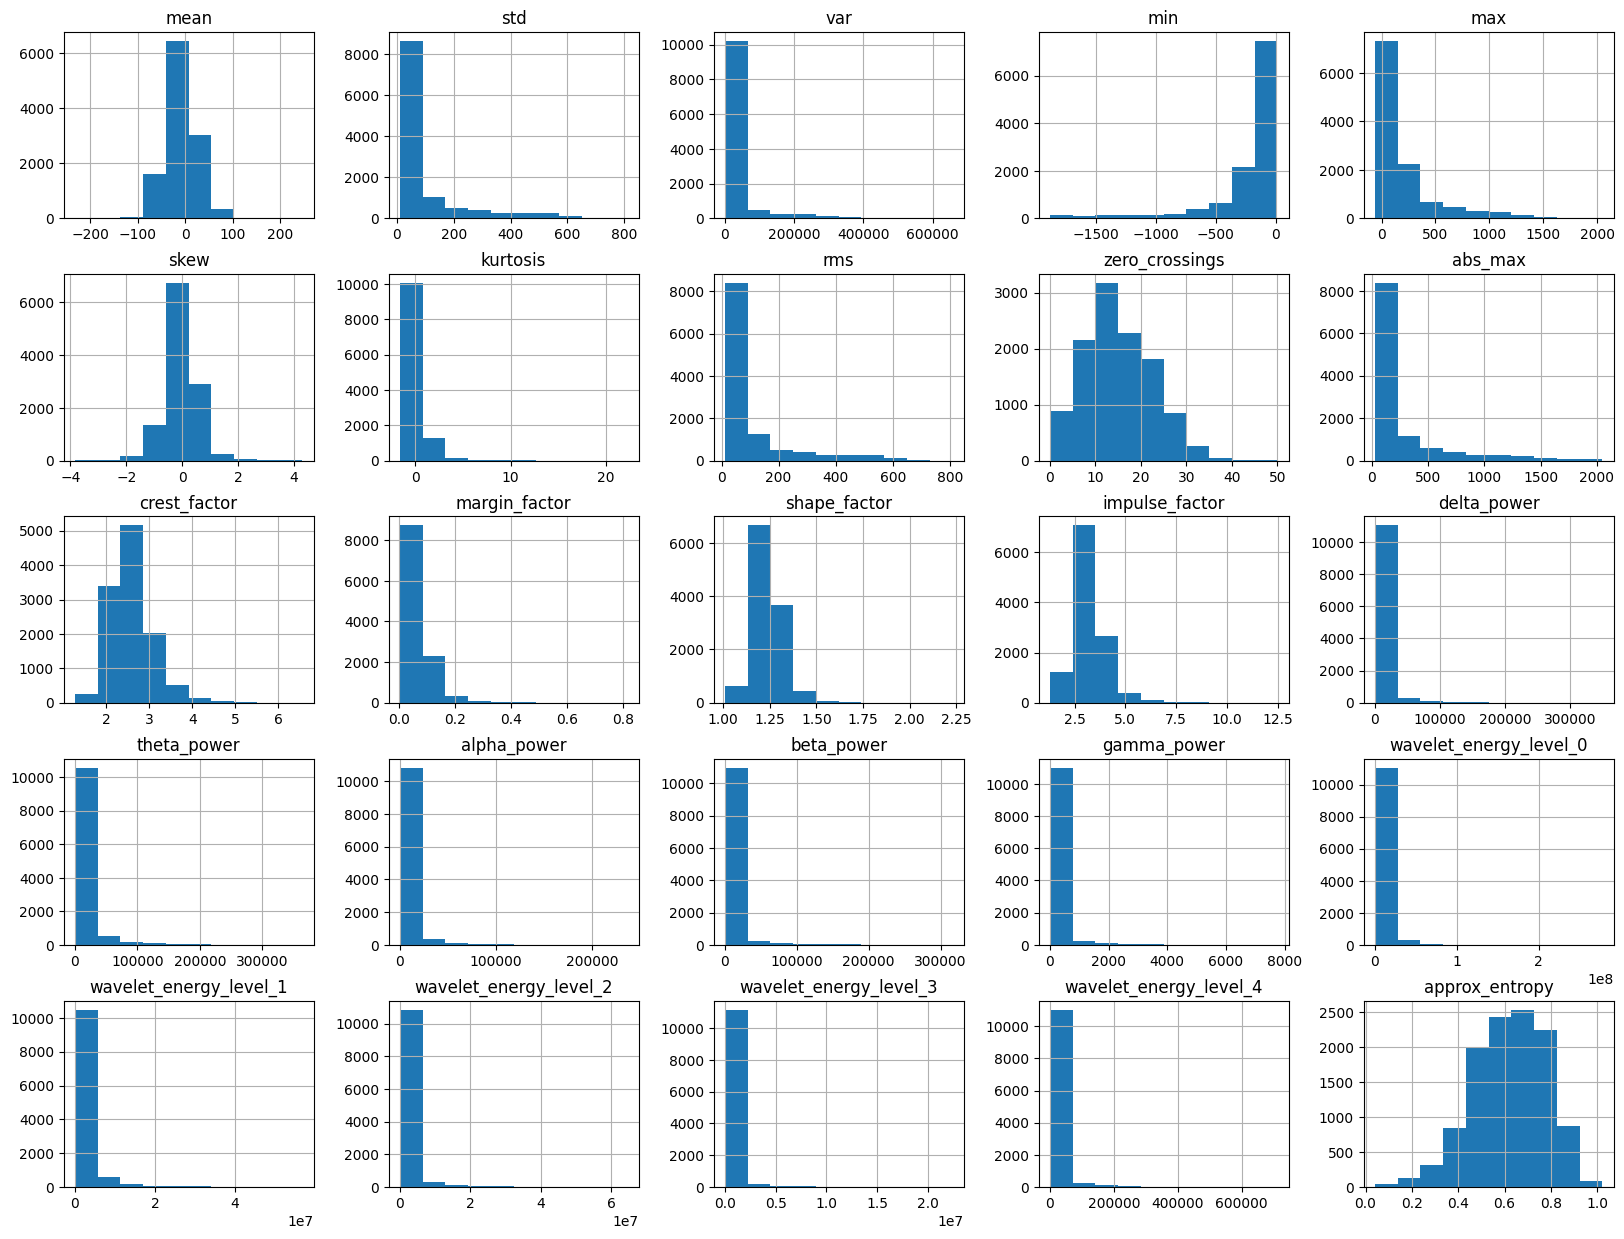

In [7]:
features_df.hist(grid=True, figsize=(20, 15))

In [8]:
# scale data

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)

According to test results, none of the features follow a normal distribution. As a result, traditional parametric methods such as **Student’s t-test** or **ANOVA**, which rely on normality assumptions, may not be suitable for all features. To systematically evaluate each feature’s ability to separate classes, we can simply employ the **Fisher Discriminant Ratio**, also known as the **Fisher Discriminability Criterion**.  

The **Fisher Discriminant Ratio** quantifies the separability of two classes by computing the ratio between inter-class variance and intra-class variance. Formally, for a given feature $X$, considering two classes $\mathcal{C}_1$ and $\mathcal{C}_2$, the FDR is defined as:

$$
\text{FDR}(X) = \frac{\left( \mu_1 - \mu_2 \right)^2}{\sigma_1^2 + \sigma_2^2}
$$

where:
- $\mu_1$ and $\mu_2$ are the means of feature $X$ for classes $\mathcal{C}_1$ and $\mathcal{C}_2$, respectively.
- $\sigma_1^2$ and $\sigma_2^2$ are the variances of feature $X$ within classes $\mathcal{C}_1$ and $\mathcal{C}_2$, respectively.

A higher FDR value indicates that the feature provides strong discrimination between the two classes, while a lower FDR suggests poor discriminative capability.

Unlike parametric tests that assume normality, the Fisher Discriminant Ratio is applicable to features with arbitrary distributions, making it a more generalizable criterion for feature selection in classification tasks.


In [9]:
def fisher_ratio(feature, labels):
    classes = np.unique(labels)
    if len(classes) != 2:
        raise ValueError("This method can only be used for binary classification but more than 2 classes were provided.")

    mu1, mu2 = scaled_features[feature][labels == classes[0]].mean(), scaled_features[feature][labels == classes[1]].mean()
    sigma1, sigma2 = scaled_features[feature][labels == classes[0]].var(), scaled_features[feature][labels == classes[1]].var()

    return (mu1 - mu2)**2 / (sigma1 + sigma2)

fdr_scores = {col: fisher_ratio(col, df_features["y"]) for col in features_df.columns}
sorted_fdr_scores = dict(sorted(fdr_scores.items(), key=lambda item: item[1], reverse=True))
sorted_fdr_scores

{'std': 2.57964960511654,
 'rms': 2.4947945332987547,
 'max': 2.148161542694318,
 'abs_max': 2.0940361846719555,
 'min': 1.6645308057189918,
 'margin_factor': 1.4740598519284658,
 'approx_entropy': 1.4658462882075847,
 'var': 1.0732609037652587,
 'wavelet_energy_level_1': 0.7540256706747539,
 'theta_power': 0.6713369524544521,
 'alpha_power': 0.5833046104580786,
 'wavelet_energy_level_0': 0.5727789379413933,
 'wavelet_energy_level_2': 0.4739477210276408,
 'delta_power': 0.364547903056898,
 'wavelet_energy_level_4': 0.3621437498138237,
 'wavelet_energy_level_3': 0.33899631162073035,
 'beta_power': 0.321223448455421,
 'gamma_power': 0.31126027697144376,
 'crest_factor': 0.06246867504538452,
 'impulse_factor': 0.058143119939758355,
 'shape_factor': 0.030042917933055763,
 'kurtosis': 0.028547676026080503,
 'mean': 0.005544583730917857,
 'skew': 0.004547628867440059,
 'zero_crossings': 0.003551560185612407}

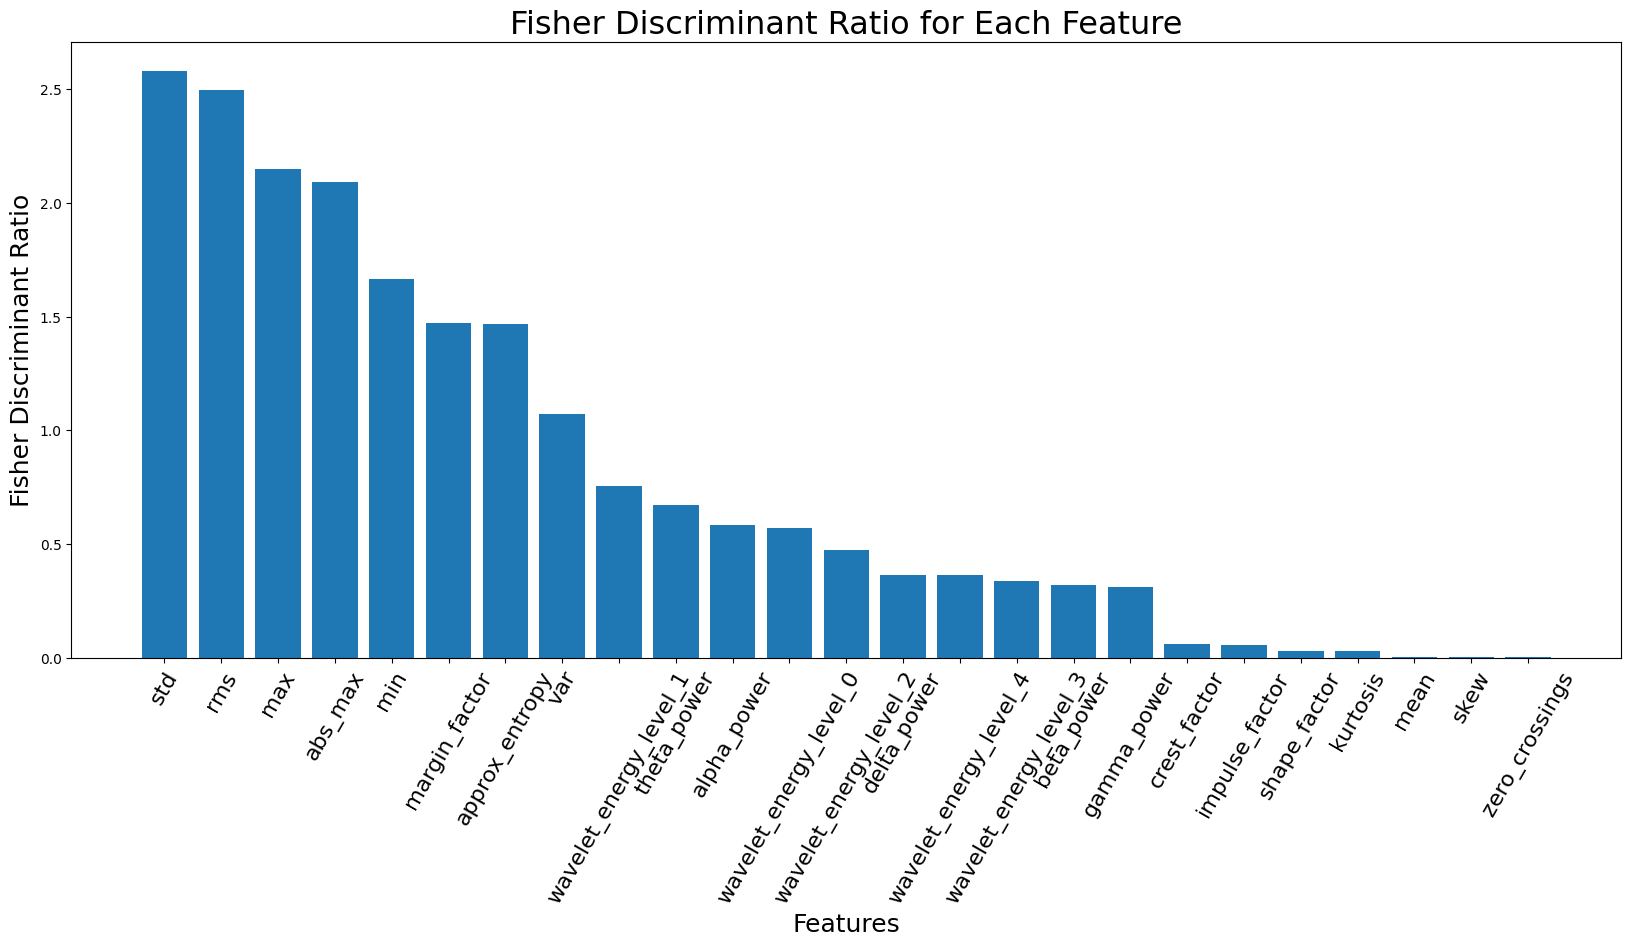

In [10]:
# plot
plt.figure(figsize=(20, 8))
plt.bar(list(sorted_fdr_scores.keys()), list(sorted_fdr_scores.values()))
plt.xticks(rotation=60, fontsize=16)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Fisher Discriminant Ratio', fontsize=18)
plt.title('Fisher Discriminant Ratio for Each Feature', fontsize=23)
plt.show()

From the visualizations, we can observe that certain features, such as the standard deviation of the series and its maximum value, exhibit strong discriminative power between seizure and non-seizure samples. In contrast, other features, such as the mean or the number of zero crossings, appear to be less effective in distinguishing between classes when considered individually.  

However, this does not necessarily mean that these features are not useful. While they may lack individual discriminative power, they could still contribute valuable information when combined with other features. Complex relationships between features often emerge in multidimensional spaces.

## Class Separability with Feature Pairs  

Class separability can also be assessed by visualizing pairs of features to observe how well they distinguish between seizure and non-seizure samples. At first glance, certain feature pairs show strong discriminative potential, indicating that some variables contribute significantly to class separation.  

However, relying on a single feature is unlikely to result in a robust classification model. EEG signals are complex, and their patterns are best captured through combinations of multiple features rather than isolated ones. To achieve optimal performance, we must select and integrate a well-balanced subset of features that work together to improve classification accuracy.


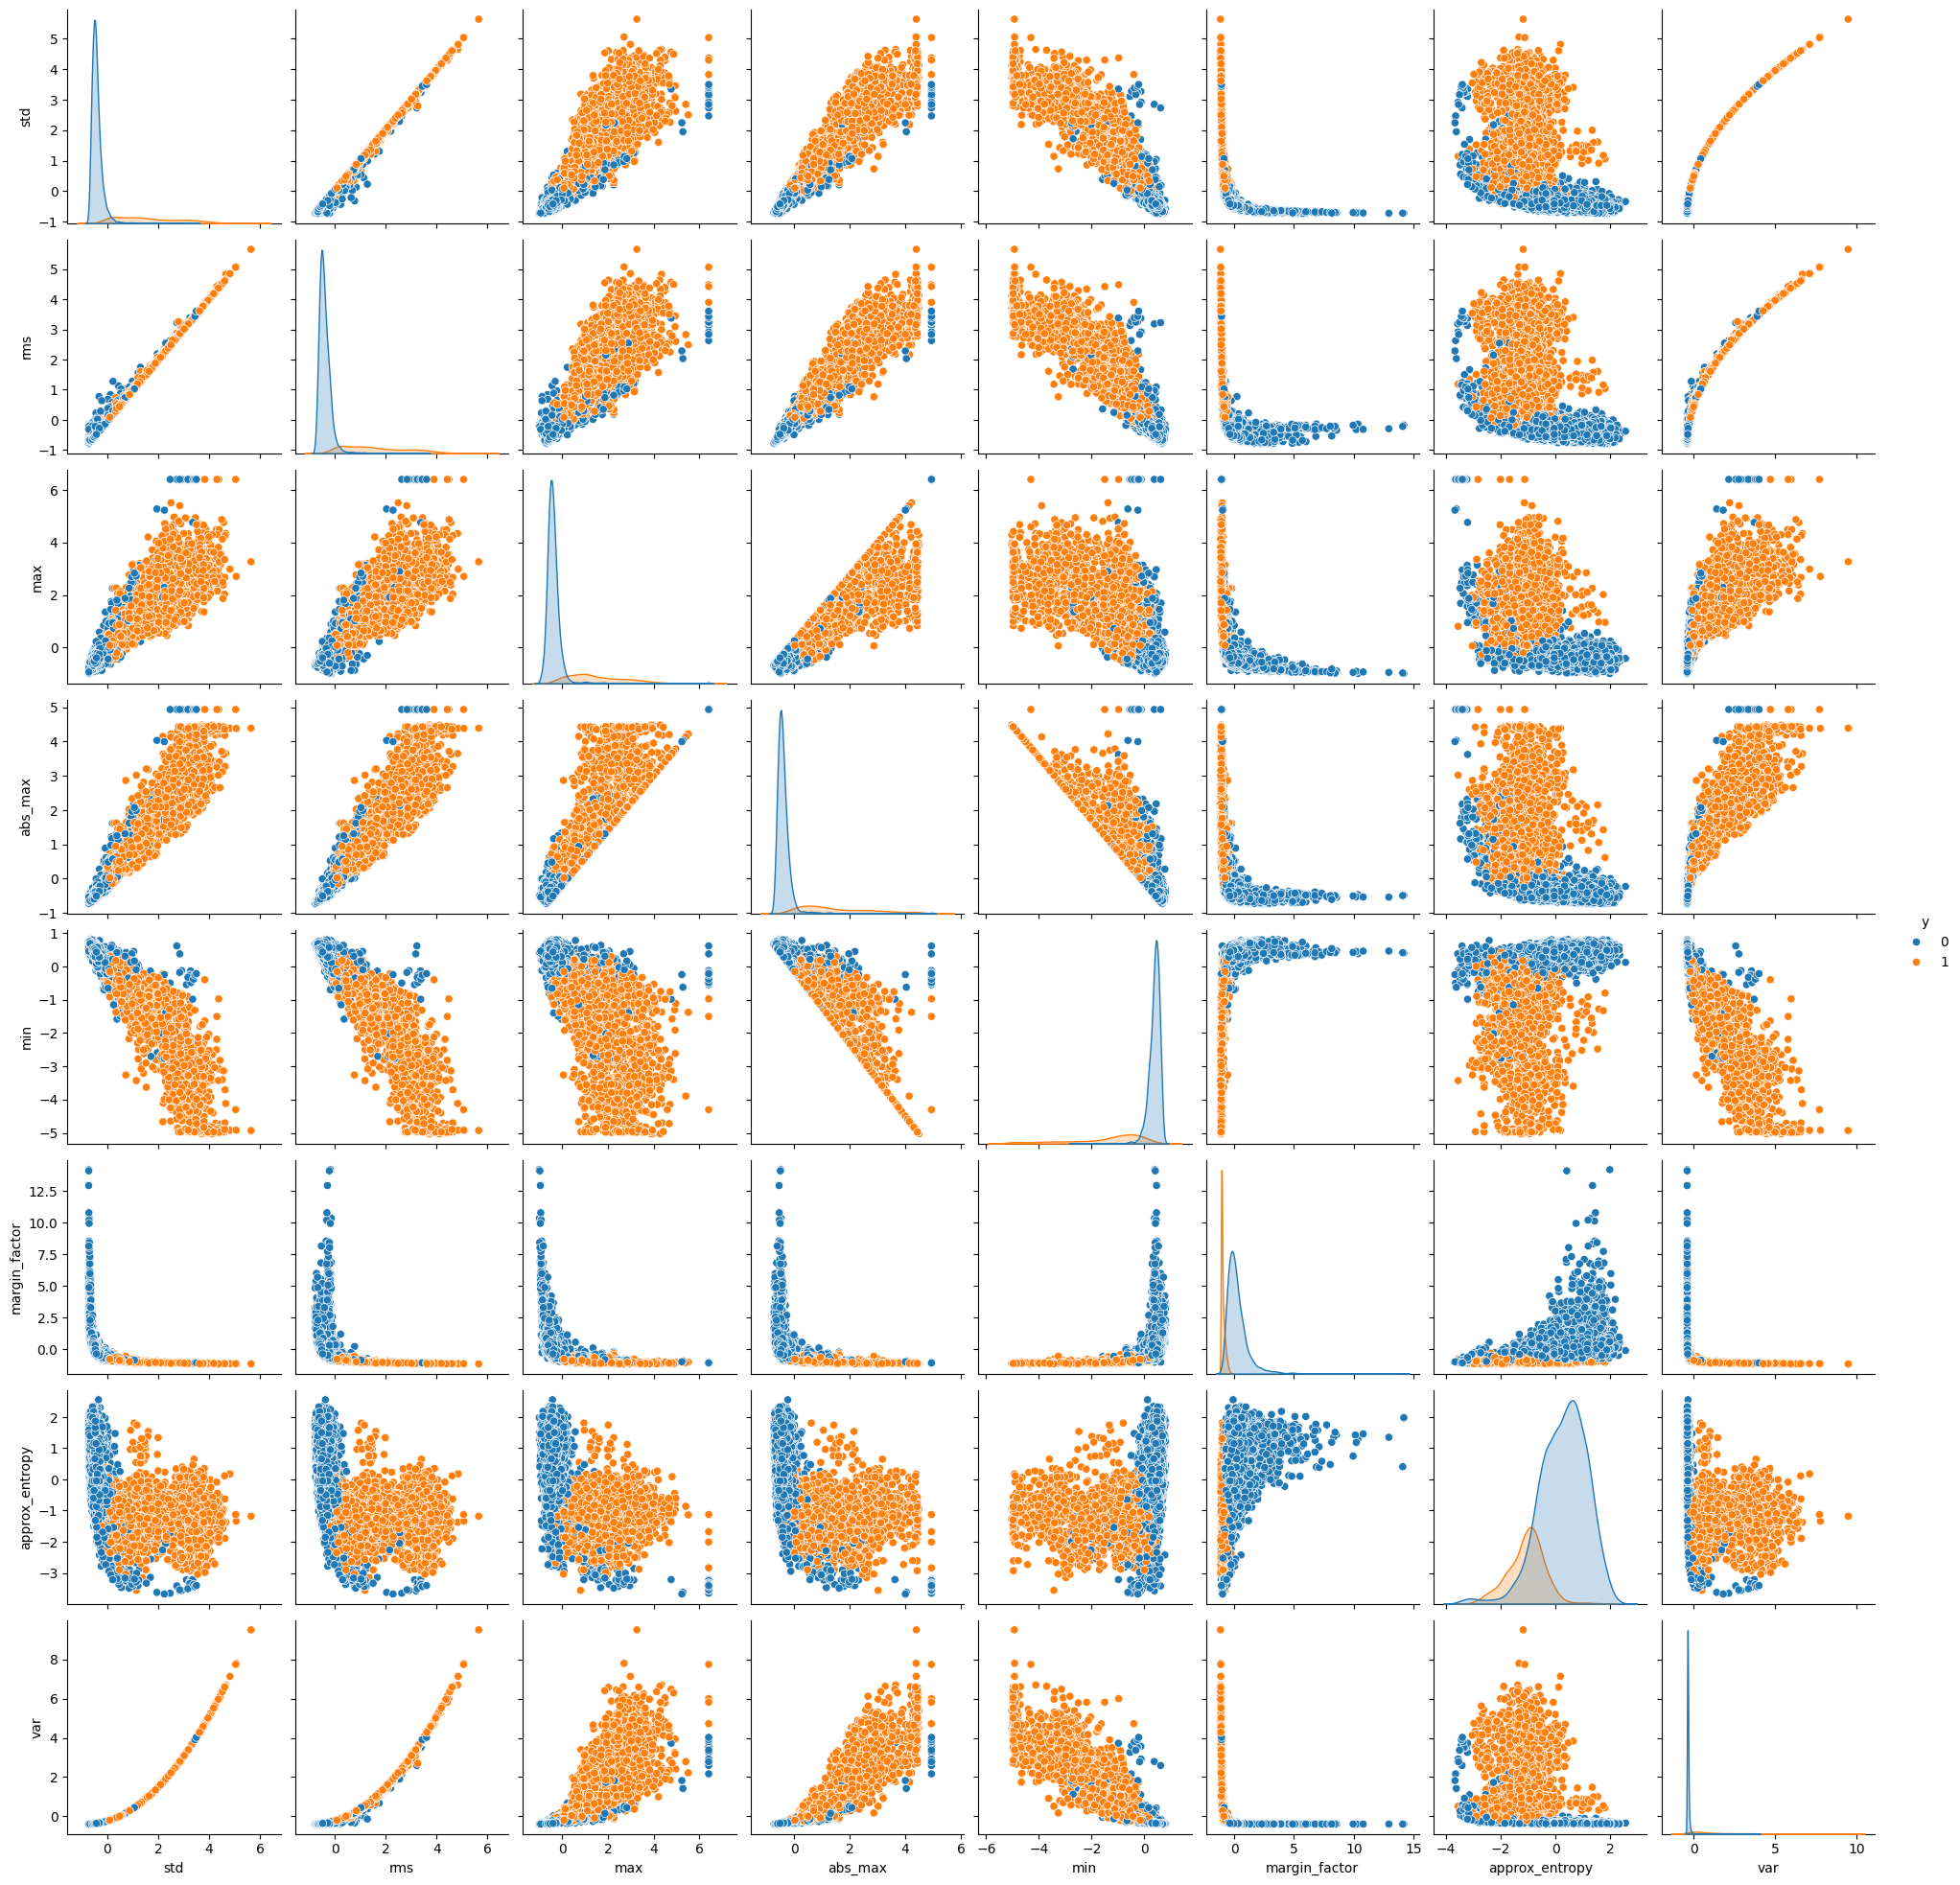

In [11]:
scaled_features_labelled = scaled_features.copy()
scaled_features_labelled["y"] = df_features["y"]
# normalize pairplot with some of the features
sns.pairplot(scaled_features_labelled[list(sorted_fdr_scores.keys())[:8]+["y"]], hue="y")

The pairplot provides a visual representation of how different feature pairs contribute to class separability. While some pairs show initial signs of separation between seizure and non-seizure samples, it is evident that a two-dimensional space is insufficient to fully distinguish both classes. This highlights the need for a combination of multiple features in higher-dimensional spaces to improve classification performance.  

Another key observation is the presence of correlations between several features, where some exhibit an almost linear relationship. This suggests potential redundancy in the dataset, as highly correlated features may not contribute unique information. We will assess this issue later in the notebook as we refine our feature selection process.


## Separability Criterion

The primary objective of this analysis is to select the most informative subset of features while considering both class separability and mutual correlations among features. This selection process is crucial in machine learning and pattern recognition, as irrelevant or redundant features can degrade classification performance. 

We will consider that a feature subset provides good separability if it maximizes inter-class variance and minimizes intra-class variance. In other words, we want samples from the same class to be as close as possible in the feature space and samples from different classes to be far apart. To compute this separability criterion we compute the following matrices:

- **Intra-Class Scatter Matrix** $ S_w $: Measures the variance within each class, quantifying how dispersed the data points are around their respective class means.
- **Inter-Class Scatter Matrix** $ S_b $: Measures the variance between class means, reflecting the separation between different classes.

Given a dataset with $ n $ samples, $ d $ features, and $ C $ classes, we define:

1. **Total Mean Vector** $ \mu_T $:
    $ \mu_T = \frac{1}{n} \sum_{i=1}^{n} x_i $
    where $ x_i $ represents a feature vector.

2. **Class-Specific Mean Vector** $ \mu_c $:
    $ \mu_c = \frac{1}{N_c} \sum_{x_i \in c} x_i $
    where $ N_c $ is the number of samples in class $ c $.

3. **Intra-Class Scatter Matrix** $ S_w $:
    $ S_w = \sum_{c=1}^{C} \sum_{x_i \in c} (x_i - \mu_c)(x_i - \mu_c)^T $
    This matrix quantifies the spread of data points around their respective class means.

4. **Inter-Class Scatter Matrix** $ S_b $:
    $ S_b = \sum_{c=1}^{C} N_c (\mu_c - \mu_T)(\mu_c - \mu_T)^T $
    This matrix captures the separation between class means and the overall mean.

The separability of classes is then evaluated using the ratio:

$ J_1 = \frac{\text{Tr}(S_b)}{\text{Tr}(S_w)} $

where $ \text{Tr}(\cdot) $ denotes the matrix trace (sum of diagonal elements). A higher $ J_1 $ value indicates better class separability, meaning that the chosen feature set effectively distinguishes between classes.


In [12]:
def criterio_separabilidad(features, labels):

    features_labelled = features.copy()
    features_labelled["y"] = labels

    # Calcular matriz de dispersión intra-clase Sw
    Sw = np.zeros((features.shape[1], features.shape[1]))
    Sb = np.zeros((features.shape[1], features.shape[1]))

    mu_total = features.mean().values.reshape(-1, 1)

    for clase in labels.unique():
        df_clase = features_labelled[features_labelled['y'] == clase].drop(columns="y") # quitamos la etiqueta para el cálculo de las medias
        mu_clase = df_clase.mean().values.reshape(-1, 1)
        
        # Matriz intra-clase
        Sw += np.cov(df_clase, rowvar=False) * len(df_clase)
        
        # Matriz inter-clase
        diff = mu_clase - mu_total
        Sb += len(df_clase) * (diff @ diff.T)

    # Criterio de separabilidad J1
    J1 = np.trace(Sb) / np.trace(Sw)
    return J1


print(f"Criterio J1: {criterio_separabilidad(scaled_features,scaled_features_labelled["y"])}") # medida de la separabilidad de clases con este conjunto


Criterio J1: 0.3630284239955988


With this feature set, we obtain a separability score of 0.3630, which indicates that the inter-class variance is not significantly larger than the intra-class variance. While some degree of separation is present, the result suggests that the current set of features may not be optimal for distinguishing between seizure and non-seizure activity.  

Given this relatively low score, a more refined selection process may be necessary to improve class separability. Further analysis will help determine which features contribute the most to discrimination and whether additional transformations or selection techniques are required.

## Analyzing Mutual Correlation

One effective way to improve separability is by eliminating redundant features, particularly those that are highly correlated. For instance, variance and standard deviation are strongly correlated since one can be derived from the other. Although both have strong individual discriminative power, including redundant information in the model is very likely to degrade performance.

In [13]:
correlation_matrix = scaled_features.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,mean,std,var,min,max,skew,kurtosis,rms,zero_crossings,abs_max,crest_factor,margin_factor,shape_factor,impulse_factor,delta_power,theta_power,alpha_power,beta_power,gamma_power,wavelet_energy_level_0,wavelet_energy_level_1,wavelet_energy_level_2,wavelet_energy_level_3,wavelet_energy_level_4,approx_entropy
mean,1.000000,0.113687,0.123318,-0.016987,0.212519,-0.009299,0.031345,0.079653,0.154683,0.108522,0.146416,-0.171581,0.171394,0.151085,0.170456,0.070267,0.083968,0.088280,0.073230,0.084962,0.065922,0.085241,0.070097,0.074008,0.000854
std,0.113687,1.000000,0.957911,-0.935807,0.920437,-0.065040,0.142118,0.995684,-0.002975,0.964979,0.171243,-0.523830,0.142711,0.173966,0.654115,0.789081,0.782370,0.683059,0.612097,0.762976,0.826396,0.777609,0.679254,0.670196,-0.546490
var,0.123318,0.957911,1.000000,-0.915336,0.853843,-0.112831,0.111401,0.956332,0.006972,0.923493,0.128806,-0.388809,0.111298,0.131868,0.661785,0.812615,0.808286,0.749241,0.637085,0.778796,0.849910,0.841579,0.735564,0.710634,-0.429914
min,-0.016987,-0.935807,-0.915336,1.000000,-0.788930,0.272316,-0.173197,-0.935610,-0.021250,-0.940285,-0.227281,0.453055,-0.151289,-0.215101,-0.637706,-0.667366,-0.756226,-0.747612,-0.673980,-0.701514,-0.734867,-0.821731,-0.753339,-0.735210,0.466491
max,0.212519,0.920437,0.853843,-0.788930,1.000000,0.180159,0.272757,0.912461,0.018325,0.923646,0.287789,-0.519505,0.252847,0.299970,0.585364,0.686513,0.715475,0.598117,0.563754,0.684790,0.728510,0.681134,0.605761,0.606190,-0.534367
skew,-0.009299,-0.065040,-0.112831,0.272316,0.180159,1.000000,0.126090,-0.064720,-0.029084,-0.060704,-0.005928,-0.039122,-0.023877,0.007021,-0.090532,-0.028361,-0.078929,-0.187092,-0.140741,-0.044661,-0.049152,-0.179679,-0.184172,-0.164284,-0.037412
kurtosis,0.031345,0.142118,0.111401,-0.173197,0.272757,0.126090,1.000000,0.143343,-0.043843,0.299019,0.722065,-0.041423,0.587251,0.759948,0.162084,-0.023307,0.074918,0.108734,0.138059,0.125121,0.016623,0.100987,0.129936,0.136243,-0.273784
rms,0.079653,0.995684,0.956332,-0.935610,0.912461,-0.064720,0.143343,1.000000,-0.047546,0.965788,0.141358,-0.482824,0.108039,0.144511,0.655015,0.786490,0.779604,0.682050,0.610955,0.766116,0.823352,0.776107,0.677973,0.668975,-0.538245
zero_crossings,0.154683,-0.002975,0.006972,-0.021250,0.018325,-0.029084,-0.043843,-0.047546,1.000000,-0.021153,0.290130,-0.218063,0.292851,0.273101,-0.090899,-0.032280,0.037977,0.121871,0.117621,-0.077899,0.000010,0.111958,0.112839,0.137788,0.379994
abs_max,0.108522,0.964979,0.923493,-0.940285,0.923646,-0.060704,0.299019,0.965788,-0.021153,1.000000,0.322979,-0.475422,0.245201,0.324809,0.682439,0.677684,0.751150,0.702774,0.651114,0.739271,0.738606,0.778749,0.711506,0.703770,-0.532803


## Feature Selection Based on Correlation and Separability

An approach to forward selection involves incorporating both correlation and the separability criterion defined earlier.  

The evaluation metric is defined as:  

$$
\text{score} = \text{separability\_term} - \text{correlation\_term}
$$

where:  

$$
\text{separability\_term} = a_1 \cdot \text{separability\_criterion}(\text{features\_df}[\text{selected\_features} + [\text{feature}]], \text{labels})
$$

$$
\text{correlation\_term} = \max \left( a_2 \cdot \left| \text{features\_df}[\text{feature}].\text{corr}(\text{features\_df}[\text{selected}]) \right| \right) , \quad \forall \text{selected} \in \text{selected\_features}
$$

where:  

- $a_1$ and $a_2$ are weighting coefficients.  
- $\text{separability\_criterion}(\cdot)$ is a function that measures class separability.  
- $\text{features\_df}$ is a DataFrame containing the extracted features.  
- $\text{selected\_features}$ represents the features that have already been selected.  
- $\text{feature}$ is the new candidate feature being evaluated.  
- $\text{labels}$ represents the class labels.  
- $\text{corr}(\cdot)$ denotes the correlation between two features.   

This method ensures that newly selected features improve class separability while minimizing redundancy introduced by highly correlated features.


In [16]:

def forward_selection(features_df, labels, criterio_separabilidad, a1=1.0, a2=1.0, max_features=None, min_improvement=1e-4):
    """
    Implementa la selección de características hacia adelante basada en la fórmula dada.

    Parámetros:
    - features_df: DataFrame de características (n_samples, n_features).
    - labels: Series o array con las etiquetas asociadas a las muestras.
    - criterio_separabilidad: función que calcula el criterio de separabilidad para un conjunto de características.
    - a1: peso para el criterio de separabilidad.
    - a2: peso para la correlación cruzada.
    - max_features: número máximo de características a seleccionar (opcional).
    - min_improvement: mejora mínima en el puntaje para continuar añadiendo características (opcional).

    Retorna:
    - selected_features: nombres de las características seleccionadas.
    """
    feature_names = features_df.columns.tolist()
    selected_features = []

    # Paso 1: Seleccionar la primera característica basada únicamente en el criterio de separabilidad
    separability_scores = {feature: criterio_separabilidad(features_df[[feature]], labels) for feature in feature_names}
    best_feature = max(separability_scores, key=separability_scores.get)
    selected_features.append(best_feature)

    # Paso 2: Iterar para seleccionar las siguientes características
    remaining_features = set(feature_names) - set(selected_features)
    last_best_score = separability_scores[best_feature]

    print("BEST SCORE:",last_best_score)
    print("ADDING NEW FEATURE:",best_feature)

    while remaining_features:
        best_score = -np.inf
        best_feature = None

        for feature in remaining_features:
            # Calcular el término de la fórmula dada
            separability_term = a1 * criterio_separabilidad(features_df[selected_features + [feature]], labels)
            correlation_term = max(a2 * abs(features_df[feature].corr(features_df[selected])) for selected in selected_features)
            score = separability_term - correlation_term

            if score > best_score:
                best_score = score
                best_feature = feature

        # Verificar criterio de parada basado en mejora mínima
        if (best_score - last_best_score) < min_improvement:
            print("Forward selection finnished because obtained score was",best_score,"which is lower than",last_best_score)
            break

        # Actualizar las características seleccionadas y el conjunto de características restantes
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        last_best_score = best_score
        print("BEST SCORE:",best_score)
        print("ADDING NEW FEATURE:",best_feature)

        # Verificar criterio de parada basado en el número máximo de características
        if max_features and len(selected_features) >= max_features:
            break

    return selected_features

selected_features = forward_selection(scaled_features, df_features["y"], criterio_separabilidad, a1=1, a2=0.5, max_features=10,min_improvement=-0.6) # como las correlaciones son muy altas entre todas las features es mejor no darle un valor muy alto término de correlación
selected_features

BEST SCORE: 1.805629548247316
ADDING NEW FEATURE: std
BEST SCORE: 1.266694943918514
ADDING NEW FEATURE: rms
BEST SCORE: 1.1453086035983517
ADDING NEW FEATURE: abs_max
BEST SCORE: 1.0722944219697648
ADDING NEW FEATURE: max
BEST SCORE: 0.9975215634693022
ADDING NEW FEATURE: min
BEST SCORE: 0.9594999991618864
ADDING NEW FEATURE: zero_crossings
BEST SCORE: 0.6336164156733879
ADDING NEW FEATURE: mean
BEST SCORE: 0.45704284707078846
ADDING NEW FEATURE: skew
BEST SCORE: 0.3507961571314847
ADDING NEW FEATURE: shape_factor
BEST SCORE: 0.214217164146854
ADDING NEW FEATURE: approx_entropy


['std',
 'rms',
 'abs_max',
 'max',
 'min',
 'zero_crossings',
 'mean',
 'skew',
 'shape_factor',
 'approx_entropy']

We generate a feature subset that provides good overall class separation without requiring a predefined classification model. This approach selects features purely based on their statistical properties, ensuring that they maximize inter-class variance while minimizing intra-class variance, while also reducing redundancy by removing highly correlated features.  

One advantage of this method is that it does not depend on a specific classification model, making it a more generalizable approach to feature selection. However, a key challenge lies in determining the optimal values for the selection coefficients, which control the trade-off between separability and correlation. Choosing inappropriate values may lead to a suboptimal feature set, either by retaining too many redundant features or by discarding informative ones. This challenge is particularly significant in contexts like this, where the dataset contains a large number of highly correlated features.

## Empiric Forward and Backward Selection

Another approach for feature selection is to use backward and forward selection to create optimal feature sets. For this purpose we will be using `sklearn` **Sequantial Feature Selector**. The **Sequential Feature Selector (SFS)** in `sklearn` is a greedy algorithm that selects a subset of features by sequentially adding or removing features based on model performance. It can be executed in two different manners:

1. **Forward Selection**: Starts with no features and iteratively adds the most important feature until the desired number of features is reached (or until performance increase is negligible).
2. **Backward Selection**: Starts with all features and iteratively removes the least important one.

The selection process is guided by a chosen evaluation metric (e.g., accuracy, RMSE). Cross-validation is typically used to assess model performance at each step.

In [ ]:
model = SVC()

# Seleccionar parsimonious para que devuelva el set lo más pequeño posible que obtiene un buen score (priorizamos reducir la dimensionalidad)
sfs = SFS(model, k_features="parsimonious", forward=True, floating=True, scoring='f1') # probablemente al ser clases desbalanceadas deberíamos usar otra métrica que no sea accuracy
sfs.fit(scaled_features, scaled_features_labelled["y"])

print(f"Selección final: {sfs.k_feature_names_}")


Selección final: None



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

The main advantage of this approach is that it selects the features that directly optimize the chosen performance metrics, ensuring that the most relevant variables for the specific model are retained.  However, a key drawback is that it introduces **inductive bias** by fixing the model beforehand. This means that the selected features are optimized for a particular classifier, potentially limiting generalization to other models or unseen data distributions.

In [ ]:
# faltan experimentos y features seleccionadasen cada uno de ellos

## Results and Conclusions from this Notebook

From this notebook, we conclude that two different feature selection strategies will be used, each resulting in a distinct feature set.  

LIST THE FEATURES

The first approach is based on **correlation and separability**, selecting features that maximize class separability while minimizing redundancy due to high correlations. This method does not rely on a specific classification model, making it more generalizable. 

The second approach follows an **empirical strategy**, selecting features that directly optimize the chosen performance metrics based on a predefined model. While effective, this method introduces an inductive bias by tailoring the selection to a specific classifier.  

By using both strategies, we can compare their effectiveness in seizure detection and assess the impact of different feature selection methods on model performance.